In [ ]:
from transformers import AutoTokenizer, MT5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import json
import warnings
import logging
from tw_rouge import get_rouge
from datasets import Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

def read_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_data = json.loads(line)  # 將每一行轉換為JSON對象
            data.append(json_data)
    return data

data = read_jsonl("./train.jsonl")
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [ ]:
checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = MT5ForConditionalGeneration.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    # Tokenize the input (maintext) in batch
    model_inputs = tokenizer(examples["maintext"], max_length=256, truncation=True)

    # Tokenize the labels (title) in batch
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["title"], max_length=64, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_data))

In [ ]:
# 對訓練和驗證數據進行預處理
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)

Map:   0%|          | 0/17368 [00:00<?, ? examples/s]

Map:   0%|          | 0/4342 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Get ROUGE scores
    result = get_rouge(decoded_preds, decoded_labels)

    # Flattening the ROUGE result dictionary for rounding
    flat_result = {}
    for k, v in result.items():
        if isinstance(v, dict):
            for sub_k, sub_v in v.items():
                flat_result[f"{k}_{sub_k}"] = sub_v
        else:
            flat_result[k] = v

    # Calculate the average prediction length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    flat_result["gen_len"] = np.mean(prediction_lens)

    # Apply rounding to the flattened result
    return {k: round(v, 4) for k, v in flat_result.items()}

training_args = Seq2SeqTrainingArguments(
    output_dir="results",
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=1500,
    eval_steps=1500,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=7,
    predict_with_generate=True,
    disable_tqdm=False,
    fp16=True
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Rouge-1 R,Rouge-1 P,Rouge-1 F,Rouge-2 R,Rouge-2 P,Rouge-2 F,Rouge-l R,Rouge-l P,Rouge-l F,Gen Len
1500,5.093500,4.099014,0.146600,0.289100,0.184600,0.051200,0.103000,0.064400,0.136000,0.269400,0.171400,13.199900
3000,4.699900,3.942287,0.165800,0.291600,0.201800,0.057900,0.100300,0.070000,0.151400,0.267100,0.184300,14.765300
4500,4.538300,3.855069,0.176900,0.287200,0.209500,0.062000,0.096800,0.072500,0.160900,0.262200,0.190600,16.423100
6000,4.445500,3.813967,0.182200,0.283600,0.212600,0.064400,0.095700,0.073800,0.165200,0.258200,0.192900,16.829800
7500,4.426800,3.796830,0.183000,0.286100,0.213800,0.064900,0.096400,0.074300,0.166400,0.261000,0.194500,16.806800


TrainOutput(global_step=7595, training_loss=4.990979309282937, metrics={'train_runtime': 4537.3516, 'train_samples_per_second': 26.794, 'train_steps_per_second': 1.674, 'total_flos': 3.213952121044992e+16, 'train_loss': 4.990979309282937, 'epoch': 7.0})

In [ ]:
trainer.save_model("./my_model")
tokenizer.save_pretrained("./my_model")

('./my_model/tokenizer_config.json',
 './my_model/special_tokens_map.json',
 './my_model/spiece.model',
 './my_model/added_tokens.json',
 './my_model/tokenizer.json')

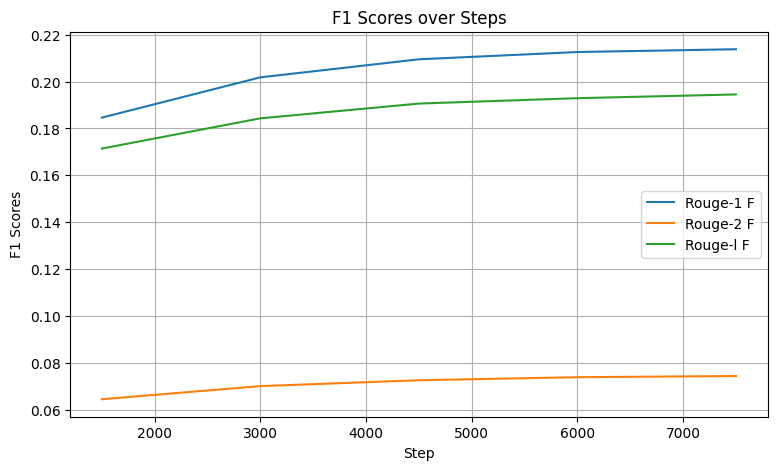

In [2]:
import matplotlib.pyplot as plt

r1_f = [0.1846, 0.2018, 0.2095, 0.2126, 0.2138]
r2_f = [0.0644, 0.0700, 0.0725, 0.0738, 0.0743]
rl_f = [0.1714, 0.1843, 0.1906, 0.1929, 0.1945]
steps = [1500, 3000, 4500, 6000, 7500]

plt.figure(figsize=(9, 5))
plt.plot(steps, r1_f, label='Rouge-1 F')
plt.plot(steps, r2_f, label='Rouge-2 F')
plt.plot(steps, rl_f, label='Rouge-l F')
plt.xlabel('Step')
plt.ylabel('F1 Scores')
plt.title('F1 Scores over Steps')
plt.legend()
plt.grid(True)
plt.show()